In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns
import config

In [2]:
sns.set_style("whitegrid")

In [3]:
#Loading coarse , bicubically interpolated and downscaled data for test set

downscaled data: 2021-2023

In [4]:
downscaled_test_dataset= xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/UNet_Deterministic_Training_Dataset/Training_Dataset_Downscaled_Predictions_2011_2020.nc")
downscaled_test_temp= downscaled_test_dataset["TabsD"]
downscaled_test_precip= downscaled_test_dataset["RhiresD"]
downscaled_test_tmin= downscaled_test_dataset["TminD"]
downscaled_test_tmax= downscaled_test_dataset["TmaxD"]

/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/MyPythonEnvNew/lib/python3.10/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


coase dataset

In [5]:
coarse_test_temp= xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Training_Chronological_Dataset/TabsD_step2_coarse.nc").sel(time=slice("2021-01-01","2023-12-31"))
coarse_test_precip= xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Training_Chronological_Dataset/RhiresD_step2_coarse.nc").sel(time=slice("2021-01-01","2023-12-31"))
coarse_test_tmin= xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Training_Chronological_Dataset/TminD_step2_coarse.nc").sel(time=slice("2021-01-01","2023-12-31"))
coarse_test_tmax= xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Training_Chronological_Dataset/TmaxD_step2_coarse.nc").sel(time=slice("2021-01-01","2023-12-31"))

bicubically interpoalted to 1 km : test set

In [6]:
input_test_temp = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Training_Chronological_Dataset/TabsD_step3_interp.nc").sel(time=slice("2021-01-01","2023-12-31"))
input_test_precip = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Training_Chronological_Dataset/RhiresD_step3_interp.nc").sel(time=slice("2021-01-01","2023-12-31"))
input_test_tmin = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Training_Chronological_Dataset/TminD_step3_interp.nc").sel(time=slice("2021-01-01","2023-12-31"))
input_test_tmax = xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Training_Chronological_Dataset/TmaxD_step3_interp.nc").sel(time=slice("2021-01-01","2023-12-31"))

In [7]:
target_temp= xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Training_Chronological_Dataset/TabsD_step1_latlon.nc").sel(time=slice("2021-01-01","2023-12-31"))
target_precip= xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Training_Chronological_Dataset/RhiresD_step1_latlon.nc").sel(time=slice("2021-01-01","2023-12-31"))
target_tmin= xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Training_Chronological_Dataset/TminD_step1_latlon.nc").sel(time=slice("2021-01-01","2023-12-31"))
target_tmax= xr.open_dataset("/work/FAC/FGSE/IDYST/tbeucler/downscaling/sasthana/Downscaling/Downscaling_Models/Training_Chronological_Dataset/TmaxD_step1_latlon.nc").sel(time=slice("2021-01-01","2023-12-31"))

In [8]:
print("coarse_test_temp dims:", coarse_test_temp.dims)
print("coarse_test_temp coords:", list(coarse_test_temp.coords))
print("input_test_temp dims:", input_test_temp.dims)
print("input_test_temp coords:", list(input_test_temp.coords))
print("downscaled_test_temp dims:", downscaled_test_temp.dims)
print("downscaled_test_temp coords:", list(downscaled_test_temp.coords))
print("target_temp dims:", target_temp.dims)
print("target_temp coords:", list(target_temp.coords))


coarse_test_temp dims: FrozenMappingWarningOnValuesAccess({'time': 1095, 'N': 21, 'E': 33})
coarse_test_temp coords: ['time', 'lon', 'lat', 'E', 'N']
input_test_temp dims: FrozenMappingWarningOnValuesAccess({'time': 1095, 'N': 240, 'E': 370})
input_test_temp coords: ['time', 'lon', 'lat', 'E', 'N']
downscaled_test_temp dims: ('time', 'lat', 'lon')
downscaled_test_temp coords: ['time', 'lat', 'lon']
target_temp dims: FrozenMappingWarningOnValuesAccess({'time': 1095, 'N': 240, 'E': 370})
target_temp coords: ['time', 'lon', 'lat', 'E', 'N']


In [9]:
def spatial_rmse(pred, target):
    target_aligned = target.sel(time=pred.time)
    # Compute RMSE over all spatial dims except time
    spatial_dims = [d for d in pred.dims if d != 'time']
    pred_mean = pred.mean(dim=spatial_dims)
    target_mean = target_aligned.mean(dim=spatial_dims)
    mask_valid = ~np.isnan(pred_mean) & ~np.isnan(target_mean)
    rmse = np.sqrt(np.mean((pred_mean[mask_valid] - target_mean[mask_valid]) ** 2))
    return float(rmse)


Bern, Geneva, Locarno, Lugano, and Z¨urich

In [10]:
cities = [
    {"name": "Geneva", "lat": 46.2044, "lon": 6.1432},
    {"name": "Zurich", "lat": 47.3769, "lon": 8.5417},
    {"name": "Bern", "lat": 46.9480, "lon": 7.4474},
    {"name": "Locarno", "lat": 46.1670, "lon": 8.7943},
    {"name": "Lugano", "lat": 46.0037, "lon": 8.9511},

]

In [11]:
from pyproj import Transformer

In [12]:
from closest_grid_cell import select_nearest_grid_cell

In [13]:
variables = [
    ("TabsD", coarse_test_temp, input_test_temp, downscaled_test_dataset, target_temp),
    ("RhiresD", coarse_test_precip, input_test_precip, downscaled_test_dataset, target_precip),
    ("TminD", coarse_test_tmin, input_test_tmin, downscaled_test_dataset, target_tmin),
    ("TmaxD", coarse_test_tmax, input_test_tmax, downscaled_test_dataset, target_tmax),
]

city_rmse = pd.DataFrame(columns=["City", "Variable", "Coarse", "Bicubic", "Downscaled"])

for city in cities:
    for var_name, coarse, bicubic, downscaled, target in variables:
        coarse_series = select_nearest_grid_cell(coarse, city["lat"], city["lon"], var_name=var_name)["data"]
        bicubic_series = select_nearest_grid_cell(bicubic, city["lat"], city["lon"], var_name=var_name)["data"]
        downscaled_series = select_nearest_grid_cell(downscaled, city["lat"], city["lon"], var_name=var_name)["data"]
        target_series = select_nearest_grid_cell(target, city["lat"], city["lon"], var_name=var_name)["data"]

        target_series = target_series.sel(time=coarse_series.time)

        coarse_rmse = float(np.sqrt(np.mean((coarse_series - target_series) ** 2)))
        bicubic_rmse = float(np.sqrt(np.mean((bicubic_series - target_series) ** 2)))
        downscaled_rmse = float(np.sqrt(np.mean((downscaled_series - target_series) ** 2)))

        city_rmse.loc[len(city_rmse)] = [city["name"], var_name, coarse_rmse, bicubic_rmse, downscaled_rmse]

print(city_rmse)


Variable 'TabsD' extracted
Time series shape: (1095,)
Data range: -4.54 to 28.66
Variable 'TabsD' extracted
Time series shape: (1095,)
Data range: -4.10 to 28.95
Variable 'TabsD' extracted
Time series shape: (1095,)
Data range: -3.53 to 29.28
Variable 'TabsD' extracted
Time series shape: (1095,)
Data range: -3.50 to 29.33
Variable 'RhiresD' extracted
Time series shape: (1095,)
Data range: 0.00 to 53.79
Variable 'RhiresD' extracted
Time series shape: (1095,)
Data range: -0.12 to 51.70
Variable 'RhiresD' extracted
Time series shape: (1095,)
Data range: 0.01 to 47.78
Variable 'RhiresD' extracted
Time series shape: (1095,)
Data range: 0.00 to 47.26
Variable 'TminD' extracted
Time series shape: (1095,)
Data range: -6.73 to 21.97
Variable 'TminD' extracted
Time series shape: (1095,)
Data range: -6.40 to 22.31
Variable 'TminD' extracted
Time series shape: (1095,)
Data range: -6.19 to 22.66
Variable 'TminD' extracted
Time series shape: (1095,)
Data range: -6.18 to 22.79
Variable 'TmaxD' extrac

In [14]:
print(city_rmse.round(2))  # Print with 2 decimals

# Or display as a nice HTML table in Jupyter
from IPython.display import display
display(city_rmse.round(2))

#Adding improvement column
city_rmse["Improvement over Bicubic (%)"] = ((city_rmse["Bicubic"] - city_rmse["Downscaled"]) / city_rmse["Bicubic"]) * 100
print(city_rmse.round(2))

       City Variable  Coarse  Bicubic  Downscaled
0    Geneva    TabsD    0.77     0.44        0.08
1    Geneva  RhiresD    1.16     0.74        0.24
2    Geneva    TminD    0.68     0.40        0.11
3    Geneva    TmaxD    0.88     0.50        0.10
4    Zurich    TabsD    0.60     0.62        0.99
5    Zurich  RhiresD    0.98     0.41        0.35
6    Zurich    TminD    0.57     0.63        1.06
7    Zurich    TmaxD    0.62     0.63        1.16
8      Bern    TabsD    0.21     0.32        0.05
9      Bern  RhiresD    0.44     0.42        0.22
10     Bern    TminD    0.22     0.33        0.05
11     Bern    TmaxD    0.22     0.36        0.06
12  Locarno    TabsD    2.83     2.65        0.42
13  Locarno  RhiresD    2.21     0.99        0.71
14  Locarno    TminD    2.25     2.26        0.61
15  Locarno    TmaxD    3.18     2.87        0.45
16   Lugano    TabsD    2.93     3.10        0.21
17   Lugano  RhiresD    2.58     1.99        0.60
18   Lugano    TminD    3.48     3.48        0.25


,City,Variable,Coarse,Bicubic,Downscaled
0,Geneva,TabsD,0.77,0.44,0.08
1,Geneva,RhiresD,1.16,0.74,0.24
2,Geneva,TminD,0.68,0.40,0.11
3,Geneva,TmaxD,0.88,0.50,0.10
4,Zurich,TabsD,0.60,0.62,0.99
5,Zurich,RhiresD,0.98,0.41,0.35
6,Zurich,TminD,0.57,0.63,1.06
7,Zurich,TmaxD,0.62,0.63,1.16
8,Bern,TabsD,0.21,0.32,0.05
9,Bern,RhiresD,0.44,0.42,0.22


       City Variable  Coarse  Bicubic  Downscaled  \
0    Geneva    TabsD    0.77     0.44        0.08   
1    Geneva  RhiresD    1.16     0.74        0.24   
2    Geneva    TminD    0.68     0.40        0.11   
3    Geneva    TmaxD    0.88     0.50        0.10   
4    Zurich    TabsD    0.60     0.62        0.99   
5    Zurich  RhiresD    0.98     0.41        0.35   
6    Zurich    TminD    0.57     0.63        1.06   
7    Zurich    TmaxD    0.62     0.63        1.16   
8      Bern    TabsD    0.21     0.32        0.05   
9      Bern  RhiresD    0.44     0.42        0.22   
10     Bern    TminD    0.22     0.33        0.05   
11     Bern    TmaxD    0.22     0.36        0.06   
12  Locarno    TabsD    2.83     2.65        0.42   
13  Locarno  RhiresD    2.21     0.99        0.71   
14  Locarno    TminD    2.25     2.26        0.61   
15  Locarno    TmaxD    3.18     2.87        0.45   
16   Lugano    TabsD    2.93     3.10        0.21   
17   Lugano  RhiresD    2.58     1.99        0

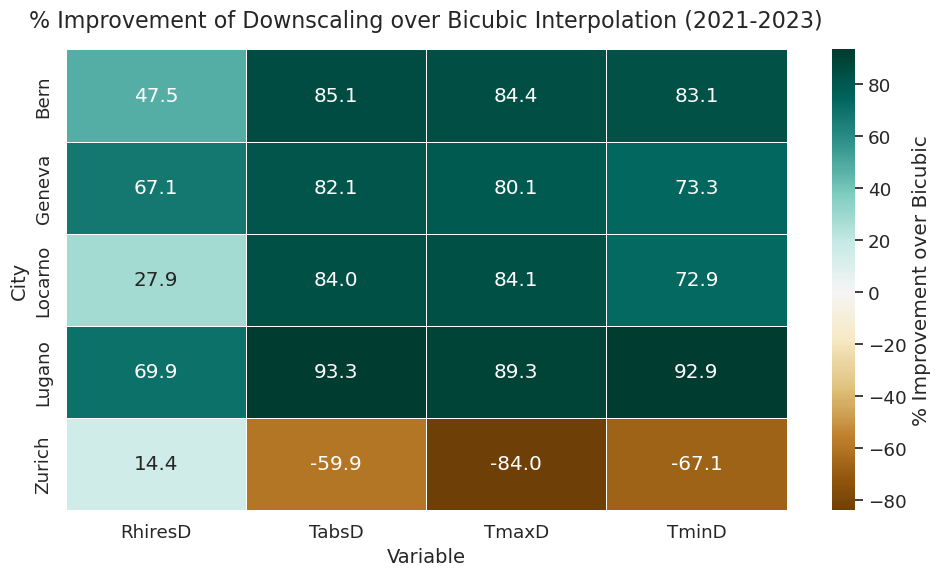

In [15]:

# Pivot for heatmap
improvement_pivot = city_rmse.pivot(index="City", columns="Variable", values="Improvement over Bicubic (%)")

plt.figure(figsize=(10, 6))
sns.set(font_scale=1.2)
ax = sns.heatmap(
    improvement_pivot,
    annot=True,
    fmt=".1f",
    cmap="BrBG",
    center=0,  # Center colormap at 0%
    linewidths=0.5,
    cbar_kws={"label": "% Improvement over Bicubic"}
)
ax.set_title("% Improvement of Downscaling over Bicubic Interpolation (2021-2023)", fontsize=16, pad=16)
ax.set_ylabel("City", fontsize=14)
ax.set_xlabel("Variable", fontsize=14)
plt.tight_layout()
plt.savefig("bicubic_improvement_heatmap.png", dpi=1000)
plt.show()